In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure, transform, img_as_float32
import skimage

from scipy import stats

from pathlib import Path

# Import normal peripheral blood cell dataset

In [2]:
path_name = '../../data/PBC_dataset_normal_df_resize_luminance.csv'
path = Path(path_name)
df = pd.read_csv(path_name)
df.head()

,img_paths,id,label,height,width,mean_brightness,mean_luminance
0,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,225079,MO,363,360,196.225564,0.756902
1,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,582430,MO,363,360,196.672727,0.757366
2,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,436409,MO,363,360,204.348235,0.797640
3,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,648815,MO,363,360,199.038259,0.770929
4,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,668574,MO,363,360,191.020018,0.734784


# Import images by categories, one after another

In [82]:
def load_image_as_grey_same_size(filename):
    image = skimage.io.imread(filename, as_gray = True)
    image = transform.resize(image, (363, 360))
    image = img_as_float32(image)  # Optional: set to your desired precision
    return image

def load_and_resize(filename):
    image = skimage.io.imread(filename)
    image = transform.resize(image, (363, 360))
    image = skimage.img_as_float64(image)
    return image

def load_and_resize32(filename):
    image = skimage.io.imread(filename)
    image = transform.resize(image, (363, 360))
    image = skimage.img_as_float32(image)
    return image

In [83]:
############################################# Mean Cells - RAM Friendly #############################################
### Lent mais peu gourmand

def plot_mean_color_cell(label):
    
    df_temp = df[df["label"] == label]['img_paths']
    N = len(df_temp)
    print('Number of cells in %s : %i'%(label, N))
    
    # Calcul des moyennes rouge, verte, bleue, rgb
    mean_red = np.zeros((363,360))
    mean_green = np.zeros((363,360))
    mean_blue = np.zeros((363,360))
    mean_rgb = np.zeros((363,360,3))
    mean_grey = np.zeros((363,360))
    
    for file in df_temp:

        image = load_and_resize(file)
        mean_red += image[:,:,0]
        mean_green += image[:,:,1]
        mean_blue += image[:,:,2]
        mean_grey += np.mean(image, axis = 2)
    
    mean_red = mean_red/N
    mean_green = mean_green/N
    mean_blue = mean_blue/N
    mean_grey = mean_grey/N
    
    # On reconstitue l'image RGB
    mean_rgb[:,:,0] = mean_red
    mean_rgb[:,:,1] = mean_green
    mean_rgb[:,:,2] = mean_blue
    
    h_red = exposure.histogram(mean_red)
    h_green = exposure.histogram(mean_green)
    h_blue = exposure.histogram(mean_blue)
    h_grey = exposure.histogram(mean_grey)
    
    # Plot images
    plt.figure(figsize = (20,8))
    
    plt.subplot(2,5,1)
    plt.title("Mean "+label+" : Rouge")
    plt.imshow(mean_red, cmap = "Reds")
    
    plt.subplot(2,5,2)
    plt.title("Mean "+label+" : Vert")
    plt.imshow(mean_green, cmap = "Greens")
    
    plt.subplot(2,5,3)
    plt.title("Mean "+label+" : Bleu")
    plt.imshow(mean_blue, cmap = "Blues")
    
    plt.subplot(2,5,4)
    plt.title("Mean "+label+" : RGB")
    plt.imshow(mean_rgb)
    
    plt.subplot(2,5,5)
    plt.title("Mean "+label+" : Grey")
    plt.imshow(mean_red, cmap = "gray")
    
    # Plot histogrammes
    plt.subplot(2,5,6)
    plt.plot(h_red[1], h_red[0], color = 'red')
    plt.title('Red-level histogram')
    
    plt.subplot(2,5,7)
    plt.plot(h_green[1], h_green[0], color = 'green')
    plt.title('Green-level histogram')
    
    plt.subplot(2,5,8)
    plt.plot(h_blue[1], h_blue[0], color = "blue")
    plt.title('Blue-level histogram')
    
    plt.subplot(2,5,9)
    plt.plot(h_red[1], h_red[0], color = "red")
    plt.plot(h_green[1], h_green[0], color = 'green')
    plt.plot(h_blue[1], h_blue[0], color = 'blue')
    plt.title('RGB histograms')
    
    plt.subplot(2,5,10)
    plt.plot(h_grey[1], h_grey[0], color = 'black')
    plt.title('Grey-level histogram')
    
    plt.show()
    
    return mean_red, mean_green, mean_blue, mean_grey


Number of cells in MO : 1420


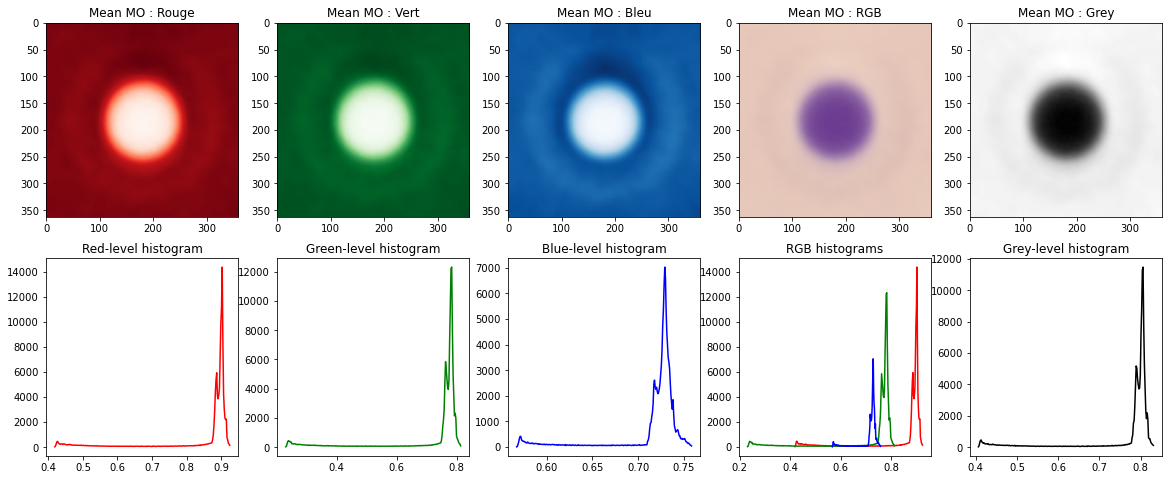

Number of cells in ERB : 1551


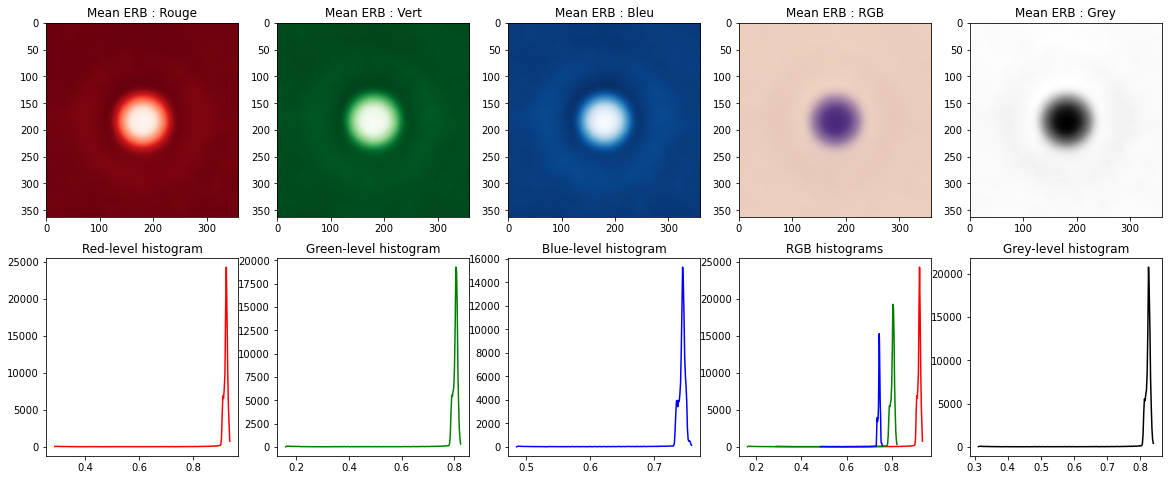

Number of cells in PLATELET : 2348


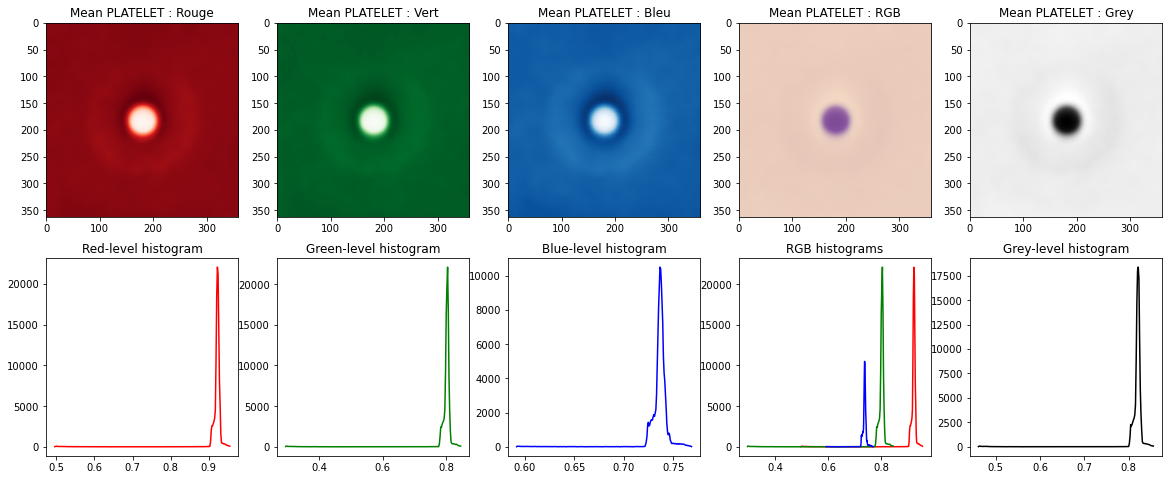

Number of cells in BA : 1218


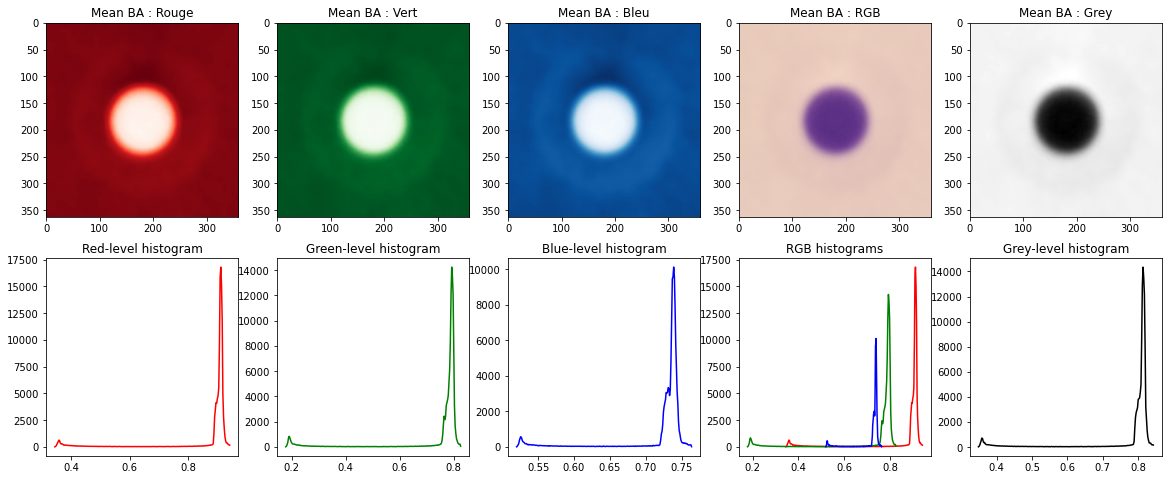

Number of cells in IG : 4528


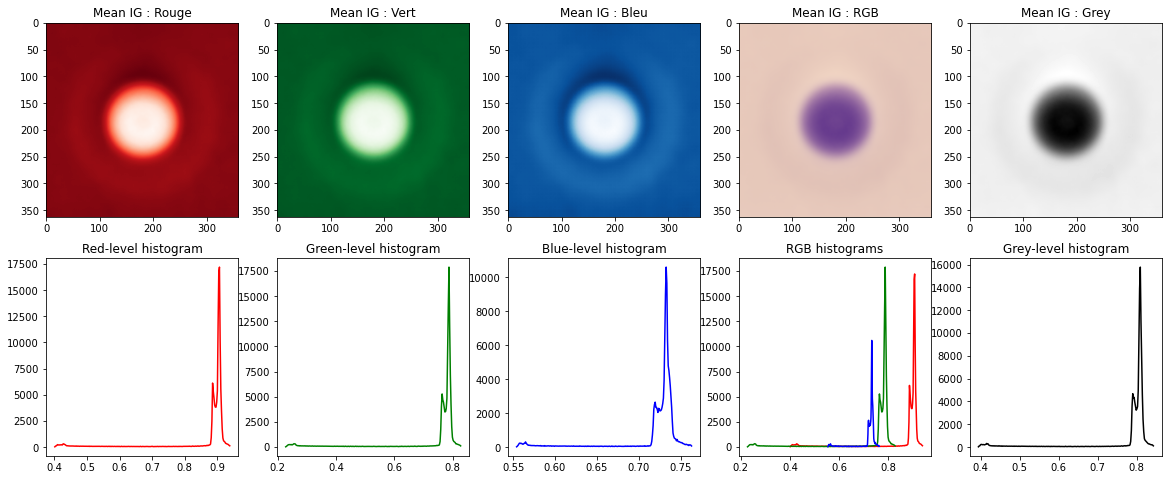

Number of cells in SNE : 1696


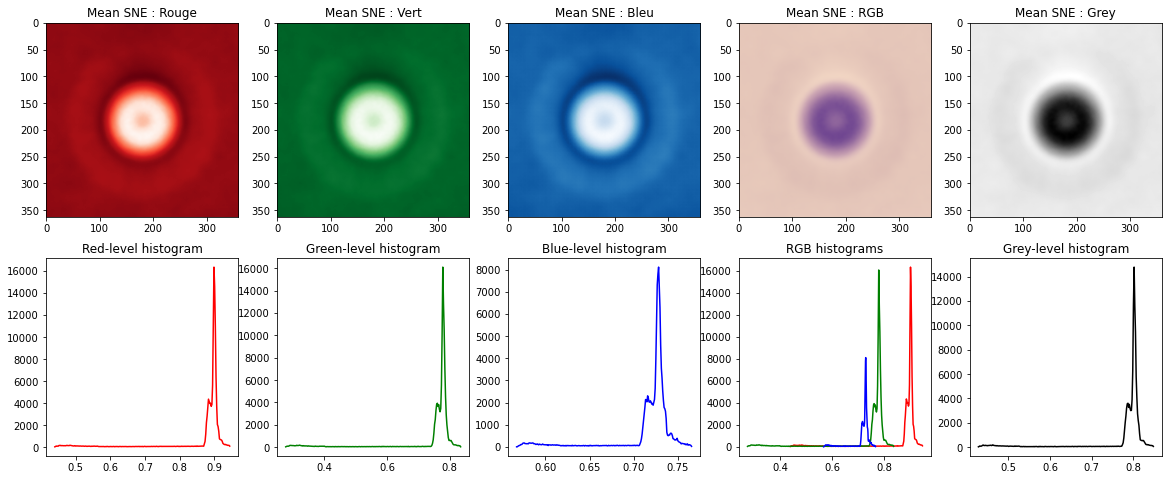

Number of cells in LY : 1214


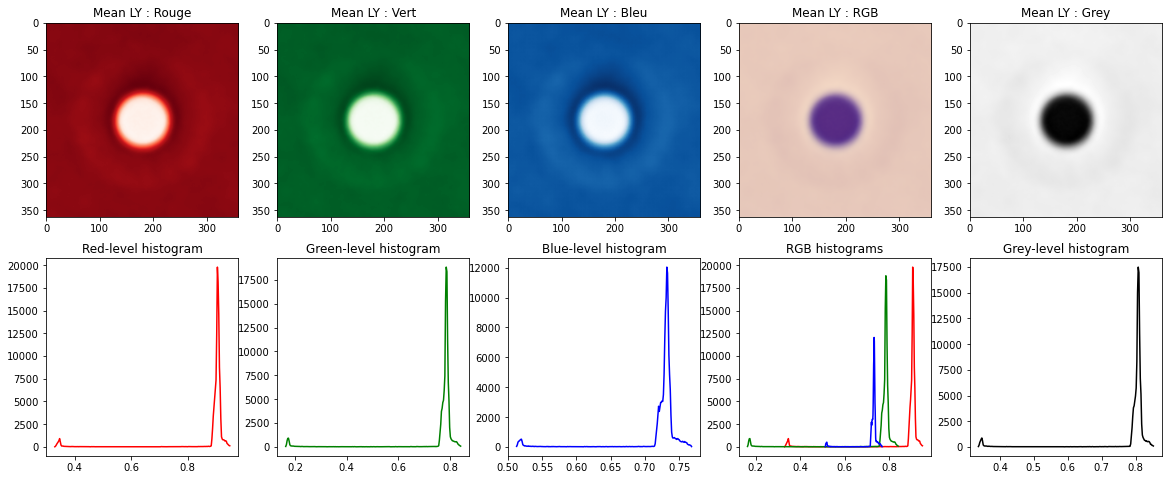

Number of cells in EO : 3117


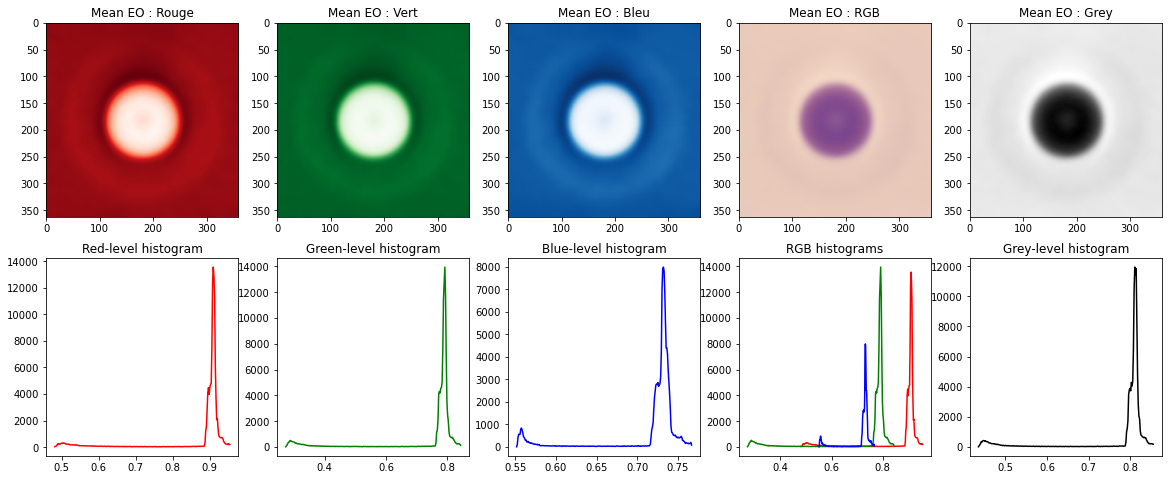

In [51]:
# Plot, classe par classe, de l'image moyenne (canaux, rvb, gray) de la cellule

classes = df['label'].unique().tolist()

df_mean = pd.DataFrame(columns = ["r","g","b","grey"])

for label in classes:
    
    reds, greens, blues, greys = plot_mean_color_cell(label)
    
    # On enfourne dans un DataFrame pour la suite ...
    df_mean.loc[label,"r"] = reds
    df_mean.loc[label,"g"] = greens
    df_mean.loc[label,"b"] = blues
    df_mean.loc[label,"grey"] = greys
    
    
### Conclusions :
# - image moyenne isotrope : pas de biais lié à l'orientation des cellules d'une classe à l'autre. 
# Si on fait de l'augmentation de données, on pourra faire des rotations d'angles aléatoires (via une distribution uniforme)
#
# - à préciser, mais a priori, pas de biais de centrage de l'image d'une classe à l'autre

In [84]:
# DataFrame contenant les données des images moyennes
df_mean.head()

,r,g,b,grey
MO,"[[0.9066527219548036, 0.9067679268774196, 0.90...","[[0.787273935407398, 0.7872340074313956, 0.787...","[[0.7318031406175852, 0.7315092572938761, 0.73...","[[0.8085765993265965, 0.8085037305342321, 0.80..."
ERB,"[[0.9300439551199038, 0.9298467355070666, 0.92...","[[0.8142528037088171, 0.8138938704894645, 0.81...","[[0.7487492592811902, 0.7483169287735846, 0.74...","[[0.831015339369969, 0.8306858449233707, 0.830..."
PLATELET,"[[0.9262534656111187, 0.926161606039351, 0.925...","[[0.8062882052310056, 0.8059708721648999, 0.80...","[[0.7389217356448509, 0.7384156729131146, 0.73...","[[0.8238211354956535, 0.8235160503724485, 0.82..."
BA,"[[0.9177452239880793, 0.9176797585187789, 0.91...","[[0.8016890332333755, 0.8013628793400078, 0.80...","[[0.7410010956664016, 0.7406904534398462, 0.74...","[[0.8201451176292861, 0.8199110304328785, 0.81..."
IG,"[[0.9120193201132007, 0.9121127274456042, 0.91...","[[0.7938621133634246, 0.7938213012328824, 0.79...","[[0.7367949862956129, 0.7364943958478624, 0.73...","[[0.8142254732573865, 0.814142808175422, 0.814..."


In [80]:
############################################## Autre version  ###############################################
### Plus rapide, plus gourmand en RAM
### On calcule aussi l'écart-type de luminosité.

def plot_mean_color_cell2(label):
    
    df_temp = df[df["label"] == label]['img_paths']
    N = len(df_temp)
    print('Number of cells in %s : %i'%(label, N))

    images = np.array([load_and_resize32(file) for file in df_temp])
    
    # Calcul des images moyennes rouge, verte, bleue, rgb, gris
    mean_red = np.mean(images[:,:,:,0], axis = 0)
    mean_green = np.mean(images[:,:,:,1], axis = 0)
    mean_blue = np.mean(images[:,:,:,2], axis = 0)
    mean_rgb = np.mean(images, axis = 0)
    mean_grey = np.mean(images, axis = (0,3))
    
    # Calcul de l'écart-type
    std_red = np.std(images[:,:,:,0], axis = 0)
    std_green = np.std(images[:,:,:,1], axis = 0)
    std_blue = np.std(images[:,:,:,2], axis = 0)
    std_rgb = np.std(images, axis = 0)
    std_grey = np.std(images.mean(axis = 3), axis = 0)
    
    # Histogrammes de luminosité
    h_red = exposure.histogram(mean_red)
    h_green = exposure.histogram(mean_green)
    h_blue = exposure.histogram(mean_blue)
    h_grey = exposure.histogram(mean_grey)

    # Plot images
    plt.figure(figsize = (20,12))
    
    plt.subplot(3,5,1)
    plt.title("Mean "+label+" : Rouge")
    plt.imshow(mean_red, cmap = "Reds")
    
    plt.subplot(3,5,2)
    plt.title("Mean "+label+" : Vert")
    plt.imshow(mean_green, cmap = "Greens")
    
    plt.subplot(3,5,3)
    plt.title("Mean "+label+" : Bleu")
    plt.imshow(mean_blue, cmap = "Blues")
    
    plt.subplot(3,5,4)
    plt.title("Mean "+label+" : RGB")
    plt.imshow(mean_rgb)
    
    plt.subplot(3,5,5)
    plt.title("Mean "+label+" : Grey")
    plt.imshow(mean_red, cmap = "gray")
    
    # Plot STDS
    plt.subplot(3,5,6)
    plt.imshow(std_red)
    plt.title("Standard Deviation "+label+" : Red")
    
    plt.subplot(3,5,7)
    plt.imshow(std_green)
    plt.title("Standard Deviation "+label+" : Green")
    
    plt.subplot(3,5,8)
    plt.imshow(std_blue)
    plt.title("Standard Deviation "+label+" : Blue")
    
    plt.subplot(3,5,9)
    plt.imshow(std_rgb)
    plt.title("Standard Deviation "+label+" : RGB")
    
    plt.subplot(3,5,10)
    plt.imshow(std_grey)
    plt.title("Standard Deviation "+label+" : Grey")
    
    # Plot histogrammes
    plt.subplot(3,5,11)
    plt.plot(h_red[1], h_red[0], color = 'red')
    plt.title('Red-level histogram')
    
    plt.subplot(3,5,12)
    plt.plot(h_green[1], h_green[0], color = 'green')
    plt.title('Green-level histogram')
    
    plt.subplot(3,5,13)
    plt.plot(h_blue[1], h_blue[0], color = "blue")
    plt.title('Blue-level histogram')
    
    plt.subplot(3,5,14)
    plt.plot(h_red[1], h_red[0], color = "red")
    plt.plot(h_green[1], h_green[0], color = 'green')
    plt.plot(h_blue[1], h_blue[0], color = 'blue')
    plt.title('RGB histograms')
    
    plt.subplot(3,5,15)
    plt.plot(h_grey[1], h_grey[0], color = 'black')
    plt.title('Grey-level histogram')
    
    plt.show()
    
    return mean_red, mean_green, mean_blue, mean_grey, std_red, std_green, std_blue, std_rgb, std_grey


Number of cells in MO : 1420


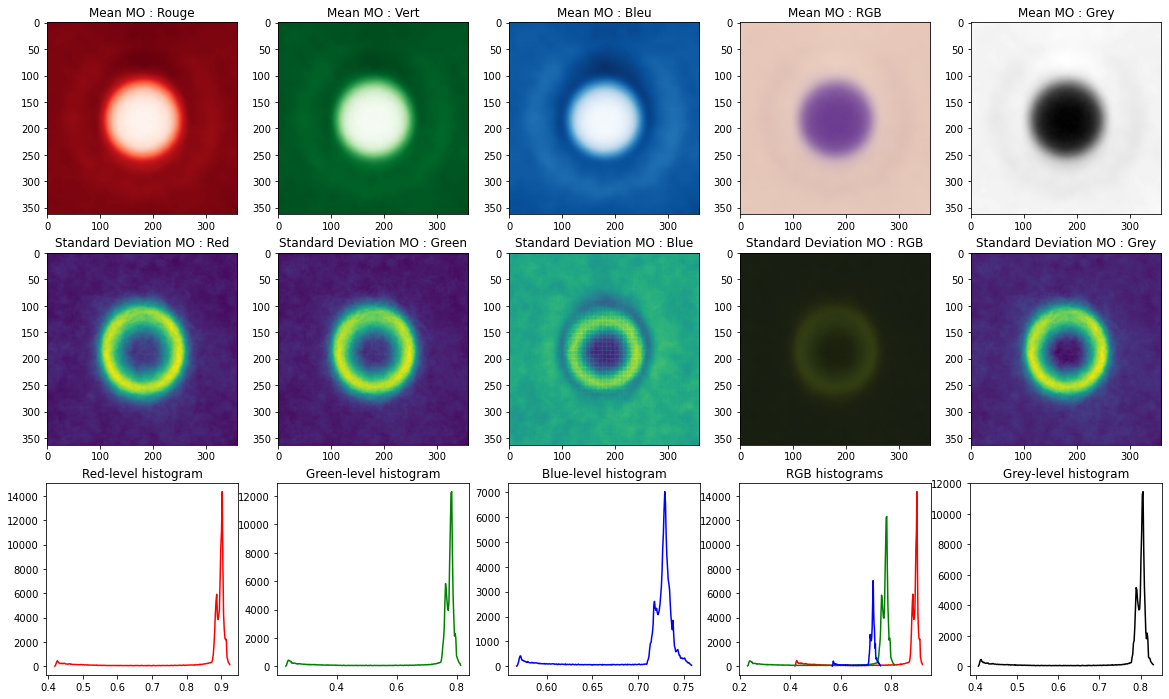

In [81]:
# Plot, classe par classe, de l'image moyenne (canaux, rvb, gray) de la cellule

classes = df['label'].unique().tolist()
#classes = ["MO"]

df_mean2 = pd.DataFrame(columns = ["r","g","b","grey","std_r","std_g","std_b","std_grey","std_rgb"])

for label in classes:
    
    reds, greens, blues, greys, stdr, stdg, stdb, stdrgb, stdgrey = plot_mean_color_cell2(label)
    
    # On enfourne dans un DataFrame pour la suite ...
    df_mean2.loc[label,"r"] = reds
    df_mean2.loc[label,"g"] = greens
    df_mean2.loc[label,"b"] = blues
    df_mean2.loc[label,"grey"] = greys
    df_mean2.loc[label,"std_r"] = stdr
    df_mean2.loc[label,"std_g"] = stdg
    df_mean2.loc[label,"std_b"] = stdb
    df_mean2.loc[label,"std_rgb"] = stdrgb   
    df_mean2.loc[label,"std_grey"] = stdgrey

In [48]:
# DataFrame contenant les données des images moyennes
df_mean2.head()

,r,g,b,grey
MO,"[[0.90665114, 0.90676624, 0.90693325, 0.907169...","[[0.7872715, 0.787232, 0.787492, 0.7879233, 0....","[[0.7318013, 0.7315072, 0.7314342, 0.7314018, ...","[[0.8085763, 0.8085042, 0.8086228, 0.8088346, ..."


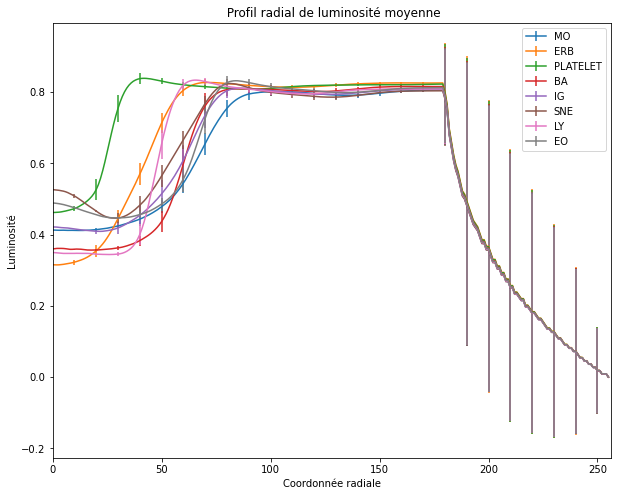

In [119]:
#### Travail sur les images en noir et blanc : passage en coordonnées polaires + profil de luminosité

#import sympy

i = 4

plt.figure(figsize = (10,8))

for cell_class in df_mean.index:

    angular_img = skimage.transform.warp_polar(df_mean.loc[cell_class,"grey"])

    radial_profile = angular_img.mean(axis = 0)
    
    # Barres d'erreur calculées par rapport à la variable angulaire (pas sur la population de cellules)
    radial_profile_std = angular_img.std(axis = 0)
    
    #deriv_radial_profile = np.gradient(radial_profile)

    plt.errorbar(x = np.arange(0, angular_img.shape[1], 1, dtype = 'int32'),
                 y = radial_profile, 
                 yerr = radial_profile_std, 
                 errorevery = 10,
                 label = cell_class)
    plt.xlim([0, angular_img.shape[1]])
    plt.xlabel('Coordonnée radiale')
    plt.ylabel('Luminosité')
    plt.title(' Profil radial de luminosité moyenne')
    
plt.legend()
plt.show()

In [ ]:
angular_img.shape[1]